In [ ]:
! pip install mofapy2
! pip install mofax
! pip install dtw-python
! pip install muon
!pip install scipy==1.7.1

In [ ]:
# download pre-trained data
! wget https://ndownloader.figshare.com/files/25502741?private_link=242916198fde3353f3e6

In [3]:
! mv 25502741?private_link=242916198fde3353f3e6 evodevo.csv
! ls

evodevo.csv  sample_data


In [73]:
import numpy as np
import pandas as pd
from mofapy2.run.entry_point import entry_point
import mofax
import seaborn as sns
import muon as mu
import scanpy as sc
# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [74]:
data = pd.read_csv('evodevo.csv', sep=',', index_col=0)
data

,group,view,sample,feature,value,time
1,Human,Brain,10wpc_Human,ENSG00000000457_Brain,8.573918,7
2,Human,Brain,10wpc_Human,ENSG00000001084_Brain,8.875957,7
3,Human,Brain,10wpc_Human,ENSG00000001167_Brain,11.265237,7
4,Human,Brain,10wpc_Human,ENSG00000001461_Brain,7.374965,7
5,Human,Brain,10wpc_Human,ENSG00000001561_Brain,7.311018,7
...,...,...,...,...,...,...
3193836,Human,Testis,youngMidAge_Human,ENSG00000271503_Testis,1.178014,21
3193837,Human,Testis,youngMidAge_Human,ENSG00000271601_Testis,1.178014,21
3193838,Human,Testis,youngMidAge_Human,ENSG00000272442_Testis,4.476201,21
3193839,Human,Testis,youngMidAge_Human,ENSG00000272886_Testis,1.178014,21


In [75]:
brain = data[data.view == 'Brain'].pivot(index='sample', columns='feature', values='value')
brain.head()

feature,ENSG00000000457_Brain,ENSG00000001084_Brain,ENSG00000001167_Brain,ENSG00000001461_Brain,ENSG00000001561_Brain,ENSG00000001617_Brain,ENSG00000001629_Brain,ENSG00000001631_Brain,ENSG00000002549_Brain,ENSG00000002745_Brain,ENSG00000002746_Brain,ENSG00000002834_Brain,ENSG00000003147_Brain,ENSG00000003249_Brain,ENSG00000003402_Brain,ENSG00000003436_Brain,ENSG00000003756_Brain,ENSG00000003987_Brain,ENSG00000003989_Brain,ENSG00000004139_Brain,ENSG00000004142_Brain,ENSG00000004399_Brain,ENSG00000004468_Brain,ENSG00000004478_Brain,ENSG00000004487_Brain,ENSG00000004534_Brain,ENSG00000004660_Brain,ENSG00000004700_Brain,ENSG00000004799_Brain,ENSG00000004838_Brain,ENSG00000004897_Brain,ENSG00000004939_Brain,ENSG00000004948_Brain,ENSG00000004961_Brain,ENSG00000005020_Brain,ENSG00000005059_Brain,ENSG00000005075_Brain,ENSG00000005102_Brain,ENSG00000005108_Brain,ENSG00000005156_Brain,...,ENSG00000250305_Brain,ENSG00000253304_Brain,ENSG00000253309_Brain,ENSG00000254087_Brain,ENSG00000255587_Brain,ENSG00000256269_Brain,ENSG00000256463_Brain,ENSG00000257923_Brain,ENSG00000258052_Brain,ENSG00000258289_Brain,ENSG00000258890_Brain,ENSG00000259494_Brain,ENSG00000259956_Brain,ENSG00000260027_Brain,ENSG00000260230_Brain,ENSG00000260234_Brain,ENSG00000260903_Brain,ENSG00000261594_Brain,ENSG00000261609_Brain,ENSG00000261717_Brain,ENSG00000263001_Brain,ENSG00000263528_Brain,ENSG00000264522_Brain,ENSG00000265107_Brain,ENSG00000265590_Brain,ENSG00000265808_Brain,ENSG00000266028_Brain,ENSG00000266074_Brain,ENSG00000266173_Brain,ENSG00000267140_Brain,ENSG00000267909_Brain,ENSG00000268104_Brain,ENSG00000269058_Brain,ENSG00000270885_Brain,ENSG00000271092_Brain,ENSG00000271503_Brain,ENSG00000271601_Brain,ENSG00000272442_Brain,ENSG00000272886_Brain,ENSG00000273079_Brain
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10wpc_Human,8.573918,8.875957,11.265237,7.374965,7.311018,9.959839,10.542619,9.692082,9.180280,4.281878,10.979023,12.434679,7.494933,9.690687,10.412416,7.680692,12.507797,8.902713,8.167553,10.726086,10.864291,10.162634,2.604549,12.158361,12.978313,12.433011,8.947791,9.828997,8.226508,5.015658,11.069285,7.325476,1.178014,8.001941,5.620371,8.203215,8.476894,2.357670,11.380042,10.328791,...,11.35208,4.503852,2.357670,6.357788,1.178014,8.540232,9.090036,11.32491,1.178014,9.174303,11.05905,7.899383,1.178014,2.023441,10.201360,1.178014,10.25520,2.805487,9.092151,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,8.028690,1.178014,7.221091,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,11.74615
11wpc_Human,8.439675,8.737682,10.855314,8.066544,7.354726,10.431113,10.308780,9.242115,9.350255,3.363064,10.910293,12.571057,8.025957,10.461891,9.946491,7.389002,12.610834,8.545327,7.198163,10.822969,11.138655,10.918804,2.818983,11.804261,12.998880,12.460042,9.412326,9.476090,7.120110,6.400409,10.523833,6.866028,1.178014,8.180023,5.441841,7.990463,9.009121,2.426565,11.173351,10.139940,...,10.87238,5.269698,2.548346,6.530228,1.406986,8.875667,8.917726,11.45153,1.178014,8.815642,10.93600,7.484305,1.178014,1.678658,9.579276,1.178014,10.50982,3.760456,8.674813,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,7.678379,1.178014,7.116983,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.421384,1.178014,11.28160
12wpc_Human,8.399178,8.916387,12.555510,9.253555,8.763702,9.946536,11.530929,10.033949,9.278142,4.322361,12.162353,12.545101,8.732905,9.809884,11.002529,8.306602,12.935439,10.438825,7.535032,10.733663,10.764443,10.552787,3.204029,11.138821,13.205963,12.320145,8.448755,10.058995,6.807524,4.804623,11.391407,5.926727,1.178014,8.155545,6.627799,5.863049,6.905500,2.664630,13.758294,10.044736,...,13.45910,5.054052,3.580839,6.857344,1.178014,8.168755,5.653118,10.85405,1.178014,9.895803,11.44668,7.661914,1.178014,1.178014,11.881160,1.178014,11.38859,3.204029,9.672895,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.17801

In [76]:
views = data.view.unique()
data_list = [data[data.view == m].pivot(index='sample', columns='feature', values='value') for m in views]
mods = {views[m]:sc.AnnData(data_list[m]) for m in range(len(views))}
mods

{'Brain': AnnData object with n_obs × n_vars = 83 × 7696,
 'Cerebellum': AnnData object with n_obs × n_vars = 83 × 7696,
 'Heart': AnnData object with n_obs × n_vars = 83 × 7696,
 'Liver': AnnData object with n_obs × n_vars = 83 × 7696,
 'Testis': AnnData object with n_obs × n_vars = 83 × 7696}

In [77]:
obs = (
    data[['sample', 'time', 'group']]
      .drop_duplicates()
      .rename(columns = {'group': 'species'})
      .set_index('sample')
)
obs.head()

,time,species
sample,,
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human


In [78]:
# create a multimodal MuData object
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

In [79]:
print(mdata)
mdata['Brain']

MuData object with n_obs × n_vars = 83 × 38480
  obs:	'time', 'species'
  5 modalities
    Brain:	83 x 7696
    Cerebellum:	83 x 7696
    Heart:	83 x 7696
    Liver:	83 x 7696
    Testis:	83 x 7696


AnnData object with n_obs × n_vars = 83 × 7696

In [80]:
mdata.obs

,time,species
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human
...,...,...
senior_Human,23,Human
teenager_Human,19,Human
toddler_Human,17,Human
youngAdult_Human,20,Human


In [82]:
mu.tl.mofa(mdata, n_factors=5, 
           groups_label="species",
           smooth_covariate='time', smooth_warping=True,
           smooth_kwargs={"warping_ref": "Mouse", "new_values": list(range(1, 15))},
           outfile="mefisto_evodevo.hdf5",
           n_iterations=25)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Brain' group='Human' with N=23 samples and D=7696 features...
Loaded view='Brain' group='Mouse' with N=14 samples and D=7696 features...
Loaded view='Brain' group='Opossum' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rabbit' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rat' with N=16 samples and D=7696 features...
Loade

In [83]:
import seaborn as sns
palette = sns.color_palette('Set2')

... storing 'species' as categorical


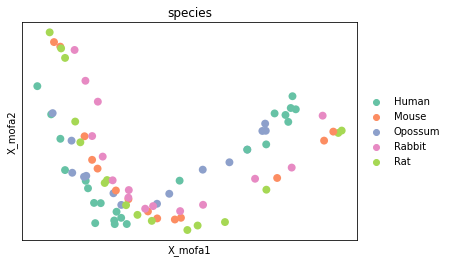

In [84]:
mu.pl.mofa(mdata, color = 'species', palette = palette, size = 250)

... storing 'species' as categorical


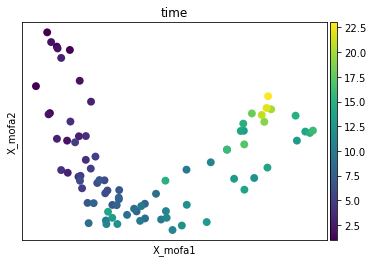

In [85]:
mu.pl.mofa(mdata, color = 'time', size = 250)

... storing 'species' as categorical


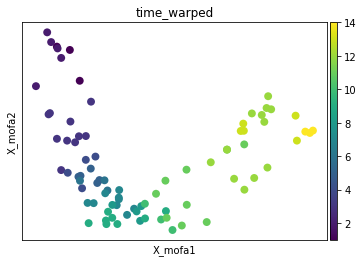

In [86]:
mu.pl.mofa(mdata, color='time_warped', size = 250)

## Latent factors vs common developmental time

In [87]:
mdata.obs['Factor1'] = mdata.obsm['X_mofa'][:, 0]

... storing 'species' as categorical


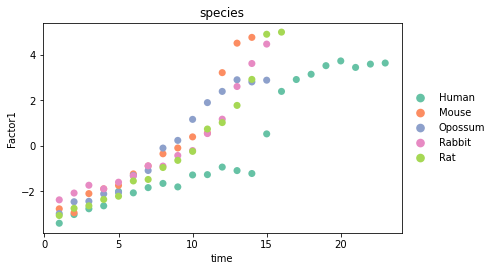

In [88]:
sc.pl.scatter(mdata, x = 'time', y = 'Factor1', color = 'species',
              palette = palette, size = 200)

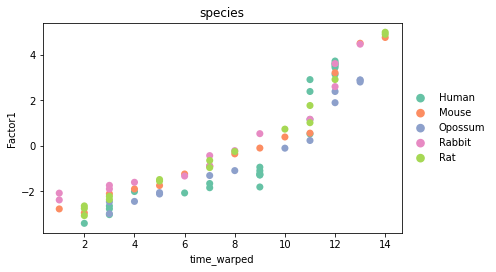

In [89]:
# after alignment
sc.pl.scatter(mdata, x = 'time_warped', y = 'Factor1', color = 'species',
              palette = palette, size=200)

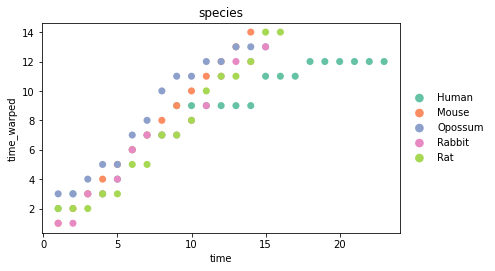

In [90]:
# Alignment
sc.pl.scatter(mdata, x = 'time', y = 'time_warped', color = 'species',
              palette = palette, size = 200)

### Smoothness and sharedness of the factors, interpolate the factors or cluster the species based on the learnt group kernel of each latent factor

In [91]:
import mofax
model = mofax.mofa_model('mefisto_evodevo.hdf5')
model

MOFA+ model: mefisto evodevo
Samples (cells): 83
Features: 38480
Groups: Human (23), Mouse (14), Opossum (15), Rabbit (15), Rat (16)
Views: Brain (7696), Cerebellum (7696), Heart (7696), Liver (7696), Testis (7696)
Factors: 5
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: time
Interpolated factors for 14 new values

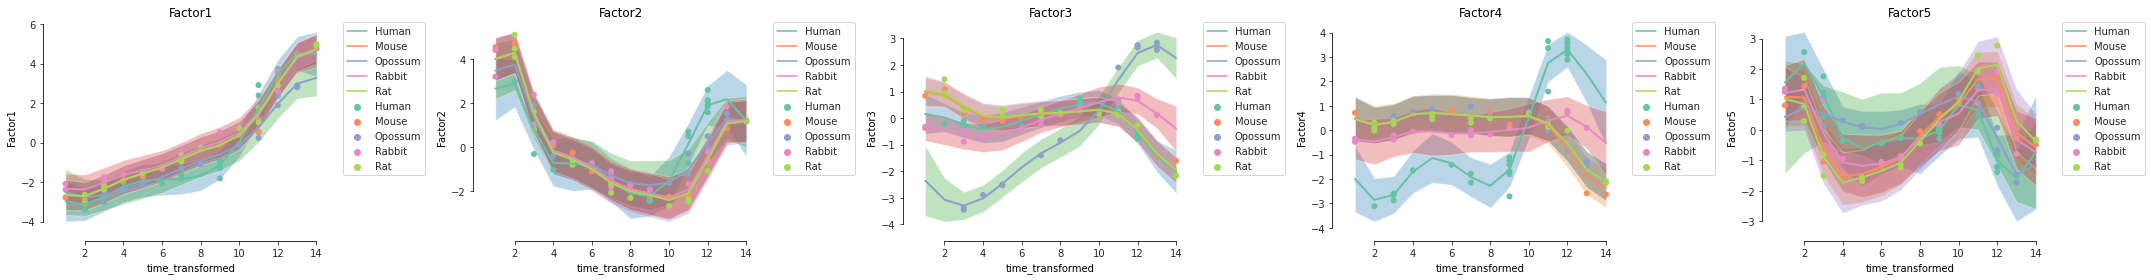

In [92]:
# Interpolation
mofax.plot_interpolated_factors(model, factors=range(model.nfactors),
                                ncols=5, size=70)

In addition to factor values and the alignment, the model also inferred an underlying Gaussian process that generated these values. By looking into it, we can extract information on the smoothness of each factor, i.e. how smoothly it varies along developmental time, as well as the sharedness of each factor, i.e. how much the species (groups) show the same underlying developmental pattern and how the shape of their developmental trajectory related to a given developmental module (Factor) clusters between species

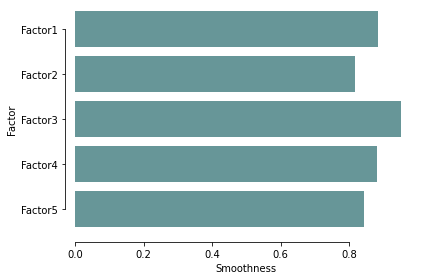

In [93]:
mofax.plot_smoothness(model)

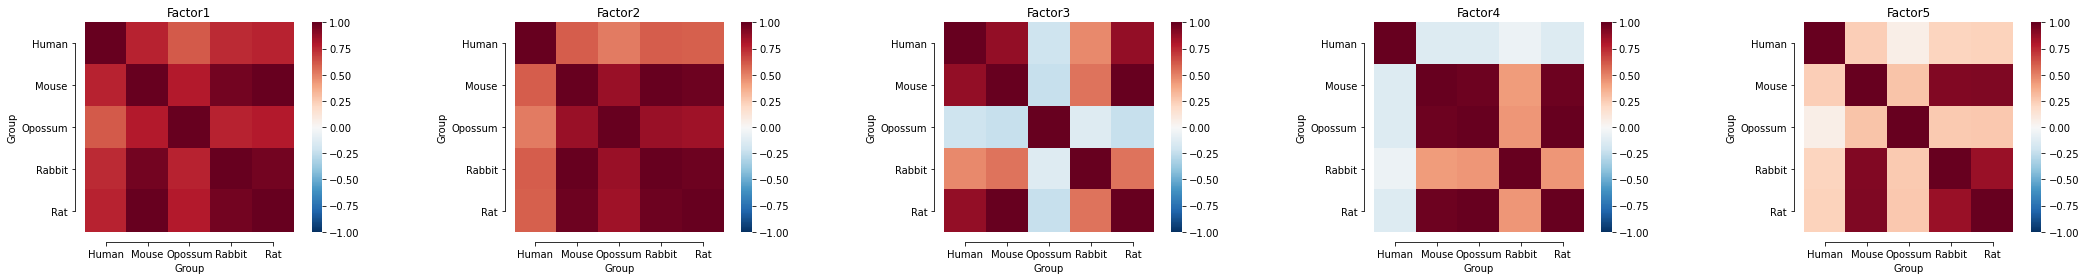

In [94]:
mofax.plot_group_kernel(model, ncols=5)

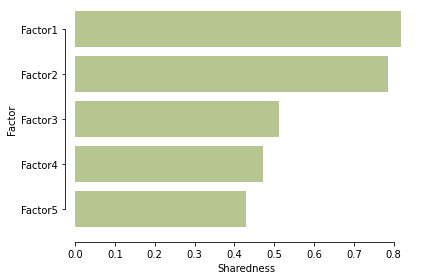

In [95]:
# Sharedness
mofax.plot_sharedness(model)

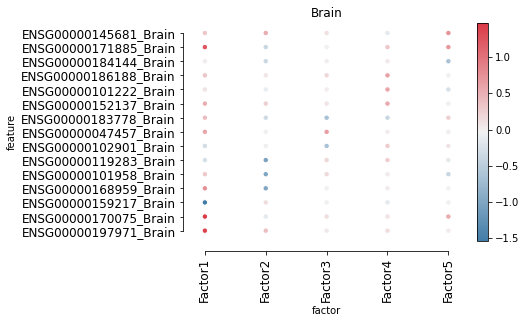

In [96]:
# Weights: insights into the molecular signatures underlying each factor
mofax.plot_weights_dotplot(model, view='Brain', n_features=3,
                           yticklabels_size=12, xticklabels_size=12,)

In [97]:
model.calculate_variance_explained()

,Group,R2,View
0,Human,63.859834,Brain
1,Mouse,84.346060,Brain
2,Opossum,70.839384,Brain
3,Rabbit,62.231903,Brain
4,Rat,84.397525,Brain
5,Human,71.311270,Cerebellum
6,Mouse,68.198315,Cerebellum
7,Opossum,60.221461,Cerebellum
8,Rabbit,46.204522,Cerebellum
9,Rat,66.691228,Cerebellum


In [98]:
model.get_factors(df=True)

,Factor1,Factor2,Factor3,Factor4,Factor5
10wpc_Human,-1.841352,-1.591422,0.225325,-2.145009,-0.223882
11wpc_Human,-1.656261,-1.600792,0.185061,-1.783160,-0.269440
12wpc_Human,-1.809035,-2.387040,0.624167,-2.709241,-0.010212
13wpc_Human,-1.284578,-2.282997,0.467703,-1.792051,-0.098471
16wpc_Human,-1.270129,-2.425247,0.735172,-1.686262,0.096555
...,...,...,...,...,...
e16_Rat,-1.547199,-0.807344,0.325702,0.613107,-1.563707
e17_Rat,-1.481874,-0.692102,0.089804,0.463957,-1.690228
e18_Rat,-0.957284,-1.680262,0.321573,0.302505,-1.237779
e19_Rat,-0.642890,-2.061700,0.081069,0.492431,-1.150006


In [99]:
model.get_views_contributions()

View,Brain,Cerebellum,Heart,Liver,Testis
sample,,,,,
10wpc_Human,0.227195,0.260313,0.241604,0.211576,0.059313
11wpc_Human,0.222039,0.257770,0.236160,0.209796,0.074236
12wpc_Human,0.223799,0.268518,0.245909,0.221356,0.040418
13wpc_Human,0.210745,0.265786,0.234884,0.220897,0.067688
16wpc_Human,0.205728,0.263413,0.230658,0.219543,0.080656
...,...,...,...,...,...
e16_Rat,0.206991,0.200102,0.198114,0.217931,0.176862
e17_Rat,0.209018,0.209063,0.195621,0.220811,0.165487
e18_Rat,0.236117,0.183030,0.198006,0.222196,0.160651


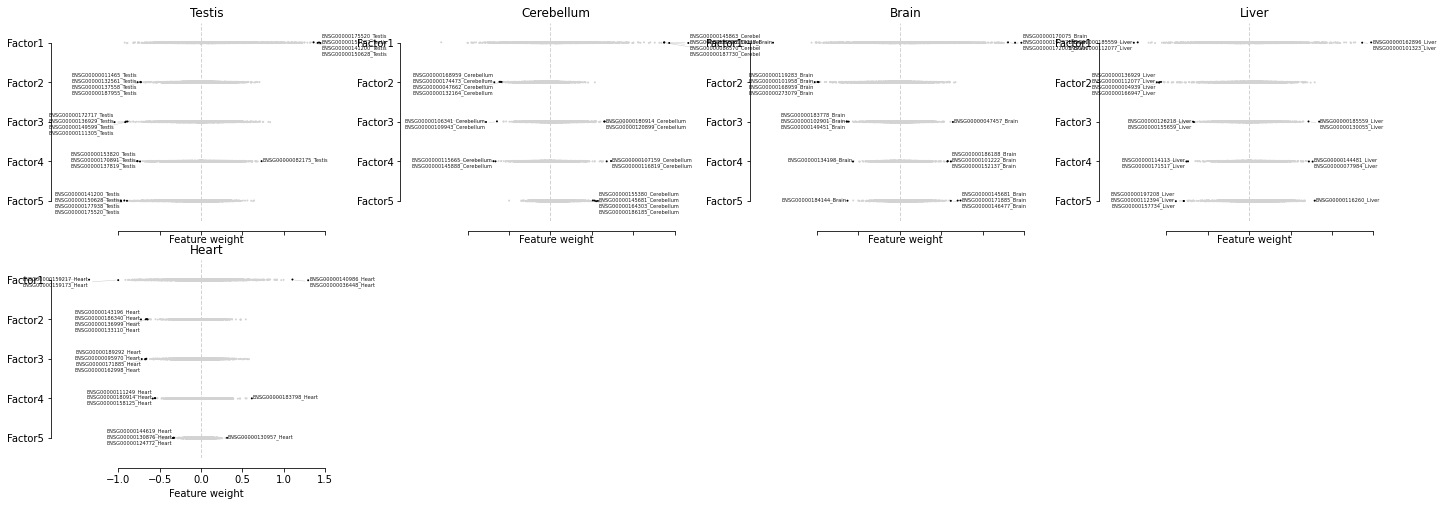

In [100]:
## Weights ranked
mofax.plot_weights(model, factor=2, n_features=4,
                   y_repel_coef=0.04, x_rank_offset=-100)

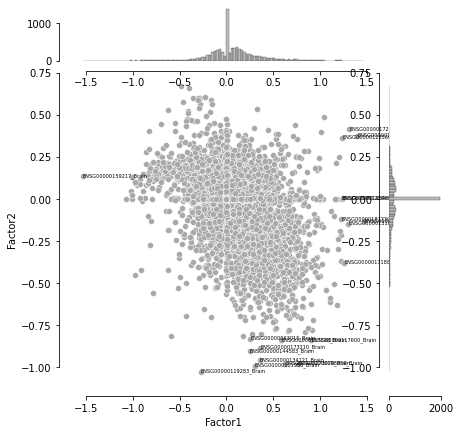

In [101]:
mofax.plot_weights_scatter(model, x = "Factor1", y = "Factor2",
                           hist = True, n_features=10)

In [102]:
model.get_top_features()

array(['ENSG00000141200_Testis', 'ENSG00000150628_Testis',
       'ENSG00000177938_Testis', 'ENSG00000175520_Testis',
       'ENSG00000174015_Testis', 'ENSG00000197208_Liver',
       'ENSG00000169340_Testis', 'ENSG00000155087_Testis',
       'ENSG00000161594_Testis', 'ENSG00000183977_Testis',
       'ENSG00000164645_Testis', 'ENSG00000116260_Liver',
       'ENSG00000112394_Liver', 'ENSG00000157734_Liver',
       'ENSG00000117152_Liver', 'ENSG00000173868_Liver',
       'ENSG00000163864_Liver', 'ENSG00000158856_Liver',
       'ENSG00000145681_Brain', 'ENSG00000136842_Liver',
       'ENSG00000102760_Liver', 'ENSG00000171885_Brain',
       'ENSG00000184144_Brain', 'ENSG00000146477_Brain',
       'ENSG00000173705_Brain', 'ENSG00000155380_Cerebellum',
       'ENSG00000134873_Brain', 'ENSG00000147862_Brain',
       'ENSG00000145681_Cerebellum', 'ENSG00000170075_Brain',
       'ENSG00000153822_Brain', 'ENSG00000144230_Brain',
       'ENSG00000164303_Cerebellum', 'ENSG00000186185_Cerebellum',
 

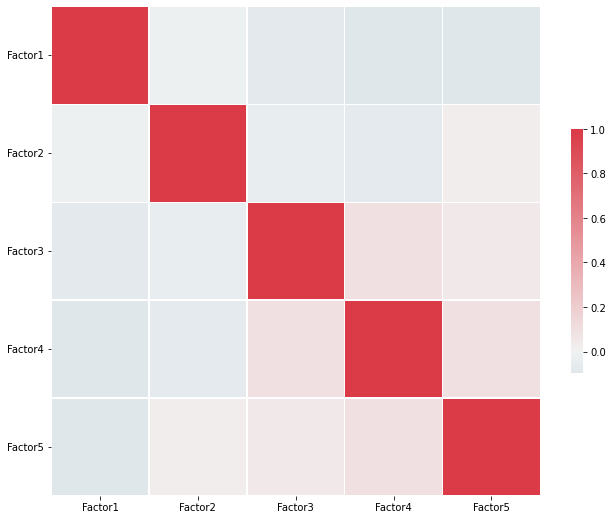

In [103]:
mofax.plot_weights_correlation(model)

In [104]:
model.get_r2()

,Factor,View,Group,R2
0,Factor1,Brain,Human,42.960238
1,Factor1,Cerebellum,Human,43.617693
2,Factor1,Heart,Human,27.307300
3,Factor1,Liver,Human,29.250493
4,Factor1,Testis,Human,29.348248
...,...,...,...,...
20,Factor5,Brain,Rat,5.120022
21,Factor5,Cerebellum,Rat,6.505168
22,Factor5,Heart,Rat,2.322075
23,Factor5,Liver,Rat,8.932678


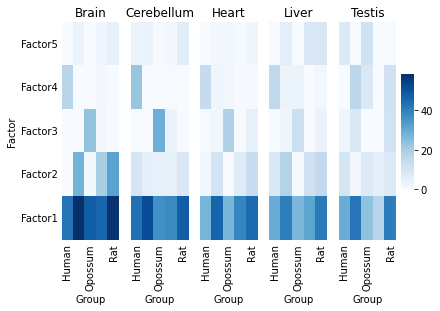

In [105]:
mofax.plot_r2(model, factors=list(range(10)), cmap='Blues')

In [106]:
model.metadata

,group,species,time
sample,,,
10wpc_Human,Human,Human,7
11wpc_Human,Human,Human,8
12wpc_Human,Human,Human,9
13wpc_Human,Human,Human,10
16wpc_Human,Human,Human,11
...,...,...,...
e16_Rat,Rat,Rat,6
e17_Rat,Rat,Rat,7
e18_Rat,Rat,Rat,8


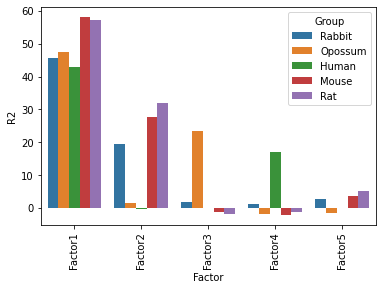

In [107]:
mofax.plot_r2_barplot(model)

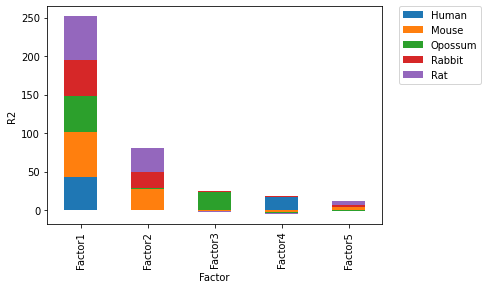

In [108]:
mofax.plot_r2_barplot(model, stacked=True)

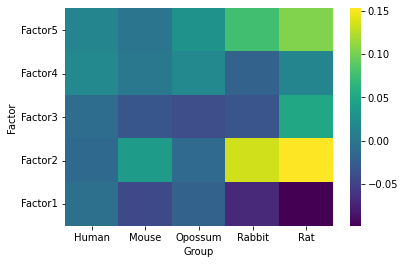

In [109]:
mofax.plot_factors_matrix(model, agg='mean')

In [110]:
model.metadata

,group,species,time
sample,,,
10wpc_Human,Human,Human,7
11wpc_Human,Human,Human,8
12wpc_Human,Human,Human,9
13wpc_Human,Human,Human,10
16wpc_Human,Human,Human,11
...,...,...,...
e16_Rat,Rat,Rat,6
e17_Rat,Rat,Rat,7
e18_Rat,Rat,Rat,8


In [111]:
model.get_top_features(factors=[1], views=['Brain'])

array(['ENSG00000119283_Brain', 'ENSG00000101958_Brain',
       'ENSG00000168959_Brain', 'ENSG00000273079_Brain',
       'ENSG00000134121_Brain', 'ENSG00000144583_Brain',
       'ENSG00000173210_Brain', 'ENSG00000117600_Brain',
       'ENSG00000117598_Brain', 'ENSG00000063015_Brain'], dtype=object)

In [112]:
model.get_views_contributions()

View,Brain,Cerebellum,Heart,Liver,Testis
sample,,,,,
10wpc_Human,0.227195,0.260313,0.241604,0.211576,0.059313
11wpc_Human,0.222039,0.257770,0.236160,0.209796,0.074236
12wpc_Human,0.223799,0.268518,0.245909,0.221356,0.040418
13wpc_Human,0.210745,0.265786,0.234884,0.220897,0.067688
16wpc_Human,0.205728,0.263413,0.230658,0.219543,0.080656
...,...,...,...,...,...
e16_Rat,0.206991,0.200102,0.198114,0.217931,0.176862
e17_Rat,0.209018,0.209063,0.195621,0.220811,0.165487
e18_Rat,0.236117,0.183030,0.198006,0.222196,0.160651


## Own data

In [189]:
data = pd.read_csv('combined.txt', sep='\t')
data.head()

,feature,time,value,sample,group,view
0,NM_001001144_Bulk,0,1729.0,RNA_Bulk_0,RNA,Bulk
1,NM_001001144_Bulk,1,2234.0,RNA_Bulk_1,RNA,Bulk
2,NM_001001144_Bulk,2,1699.5,RNA_Bulk_2,RNA,Bulk
3,NM_001001144_Bulk,3,1205.0,RNA_Bulk_3,RNA,Bulk
4,NM_001001144_Bulk,4,1226.0,RNA_Bulk_4,RNA,Bulk


In [190]:
bulk = data[data.view == 'Bulk'].pivot(index='sample', columns = 'feature', values='value')
bulk.head()

feature,NM_001001144_Bulk,NM_001001181_Bulk,NM_001001182_Bulk,NM_001001185_Bulk,NM_001001295_Bulk,NM_001001326_Bulk,NM_001001491_Bulk,NM_001001493_Bulk,NM_001001565_Bulk,NM_001001806_Bulk,NM_001001881_Bulk,NM_001001882_Bulk,NM_001001892_Bulk,NM_001001932_Bulk,NM_001001983_Bulk,NM_001001984_Bulk,NM_001002004_Bulk,NM_001002008_Bulk,NM_001002011_Bulk,NM_001002764_Bulk,NM_001002929_Bulk,NM_001003908_Bulk,NM_001003912_Bulk,NM_001003918_Bulk,NM_001003934_Bulk,NM_001003949_Bulk,NM_001003950_Bulk,NM_001003953_Bulk,NM_001003955_Bulk,NM_001003961_Bulk,NM_001004062_Bulk,NM_001004066_Bulk,NM_001004140_Bulk,NM_001004143_Bulk,NM_001004144_Bulk,NM_001004164_Bulk,NM_001004185_Bulk,NM_001004191_Bulk,NM_001004361_Bulk,NM_001004362_Bulk,...,NM_207110_Bulk,NM_207161_Bulk,NM_207204_Bulk,NM_207207_Bulk,NM_207209_Bulk,NM_207213_Bulk,NM_207214_Bulk,NM_207215_Bulk,NM_207220_Bulk,NM_207225_Bulk,NM_207234_Bulk,NM_207237_Bulk,NM_207239_Bulk,NM_207255_Bulk,NM_207298_Bulk,NM_207301_Bulk,NM_207302_Bulk,NM_207525_Bulk,NM_207530_Bulk,NM_207541_Bulk,NM_207625_Bulk,NM_207633_Bulk,NM_207636_Bulk,NM_207653_Bulk,NM_207654_Bulk,NM_207655_Bulk,NM_207659_Bulk,NM_207671_Bulk,NM_207677_Bulk,NM_207678_Bulk,NM_211358_Bulk,NM_212433_Bulk,NM_212445_Bulk,NM_212446_Bulk,NM_212450_Bulk,NM_212473_Bulk,NM_212484_Bulk,NM_213614_Bulk,NM_213659_Bulk,NM_213733_Bulk
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RNA_Bulk_0,1729.0,62.5,70.5,56.5,258.0,617.0,460.5,48.5,930.5,974.0,46.5,725.0,320.0,68.0,1166.0,598.5,2372.5,22.0,14923.0,388.0,943.5,1367.0,823.5,292.0,299.5,1568.5,180.5,413.5,505.0,28.5,189.0,16.5,192.0,685.0,705.5,191.0,78.5,102.0,78.0,57.5,...,297.5,152.0,223.0,269.0,424.5,182.0,51.0,265.0,172.5,226.5,119.5,275.5,1956.5,226.0,91.5,87.5,95.5,145.5,217.5,7.0,97.5,58.0,257.5,52.0,15.0,429.5,99.0,76.5,39.5,348.5,65.5,148.0,131.0,172.5,23.5,53.5,150.5,1078.0,812.5,136.0
RNA_Bulk_1,2234.0,63.0,60.5,38.5,229.5,330.5,167.0,67.0,856.0,499.0,39.5,886.0,620.0,96.0,1202.0,701.0,4734.0,16.5,7255.5,237.5,1092.5,1773.0,731.0,532.0,676.5,2045.5,256.5,549.5,226.5,62.5,183.0,20.5,137.0,519.0,685.0,976.5,204.0,81.5,47.0,19.5,...,303.0,204.5,73.5,450.0,603.0,197.0,60.5,317.5,138.5,270.0,162.5,87.5,3394.0,148.0,53.0,172.5,97.5,146.5,261.0,9.0,97.0,54.5,175.0,38.5,25.0,369.5,70.0,98.5,85.5,384.0,148.5,146.5,140.0,186.5,21.5,149.5,206.0,197.5,983.0,311.0
RNA_Bulk_2,1699.5,133.0,49.0,37.0,295.0,158.5,127.5,62.0,321.5,129.0,64.0,1087.0,800.0,79.0,1133.0,627.5,6131.0,14.0,4505.5,247.0,913.0,2019.5,702.5,435.0,896.0,2389.5,574.0,398.0,258.5,38.0,63.5,23.5,67.5,426.5,542.5,714.0,335.5,253.5,37.0,29.0,...,264.0,60.0,49.0,601.5,465.5,212.5,81.5,287.0,226.5,247.5,177.5,67.0,2966.0,107.0,27.0,140.0,147.0,182.5,268.0,7.5,120.0,105.5,197.5,122.5,17.0,84.5,79.0,107.5,150.0,516.0,52.0,252.0,87.0,201.5,31.0,250.5,169.0,160.5,987.0,414.0
RNA_Bulk_3,1205.0,72.5,60.0,18.5,300.0,169.5,206.0,37.5,256.5,180.5,42.0,783.5,1276.5,93.5,877.5,657.0,5267.0,15.0,5251.0,236.5,814.0,1899.0,683.0,398.0,755.0,1779.0,386.0,342.5,207.0,28.0,44.0,25.0,86.0,366.0,479.5,696.0,325.5,244.0,26.5,35.0,...,220.0,69.0,50.5,470.5,356.5,270.0,71.0,330.5,203.5,272.5,92.0,87.0,2003.0,108.5,33.5,80.5,125.5,200.0,305.5,8.0,142.5,68.0,201.0,151.0,19.0,55.5,66.0,111.0,134.5,435.5,46.0,203.5,76.0,156.5,36.0,246.0,180.5,208.5,1009.5,398.0
RNA_Bulk_4,1226.0,77.0,139.5,15.5,481.0,159.0,180.0,27.0,275.5,298.5,24.0,805.5,1307.5,251.0,1209.0,1009.5,5929.5,37.5,3398.5,344.0,779.5,3139.5,852.5,698.5,919.0,2109.5,401.0,355.5,186.5,24.5,46.0,56.5,147.5,389.0,764.0,739.0,409.5,194.5,27.5,65.0,...,301.0,53.0,56.0,365.0,581.5,383.5,133.5,670.0,138.0,298.0,107.0,107.0,1802.5,144.5,23.5,71.0,181.0,197.0,377.5,16.5,329.0,110.0,374.0,207.0,39.5,81.5,189.5,263.0,140.0,570.5,67.0,352.0,93.5,137.0,86.0,236.0,193.0,117.5,1173.0,304.5


In [191]:
views = data.view.unique()
views
data_list = [data[data.view == m].pivot(index='sample', columns='feature', values='value') for m in views]
mods = {views[m]:sc.AnnData(data_list[m]) for m in range(len(views))}
mods

{'Bulk': AnnData object with n_obs × n_vars = 14 × 8453,
 'Crude': AnnData object with n_obs × n_vars = 14 × 8453,
 'Cyto': AnnData object with n_obs × n_vars = 14 × 8453}

In [192]:
obs = (
    data[['sample', 'time', 'group']]
        .drop_duplicates()
        .rename(columns = {'group' : 'type'})
        .set_index('sample')
)
obs.head()

,time,type
sample,,
RNA_Bulk_0,0,RNA
RNA_Bulk_1,1,RNA
RNA_Bulk_2,2,RNA
RNA_Bulk_3,3,RNA
RNA_Bulk_4,4,RNA


In [193]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

In [194]:
print(mdata)
mdata['Crude']

MuData object with n_obs × n_vars = 42 × 25359
  obs:	'time', 'type'
  3 modalities
    Bulk:	14 x 8453
    Cyto:	14 x 8453
    Crude:	14 x 8453


AnnData object with n_obs × n_vars = 14 × 8453

In [195]:
mdata.obs

,time,type
RNA_Bulk_0,0,RNA
RNA_Bulk_1,1,RNA
RNA_Bulk_2,2,RNA
RNA_Bulk_3,3,RNA
RNA_Bulk_4,4,RNA
RNA_Bulk_5,5,RNA
RNA_Bulk_6,6,RNA
RPF_Bulk_0,0,RPF
RPF_Bulk_1,1,RPF
RPF_Bulk_2,2,RPF


In [197]:
mu.tl.mofa(mdata, n_factors=4, use_obs='union',
           groups_label="type",
           smooth_covariate='time', smooth_warping=False,
           smooth_kwargs={"warping_ref": "RNA", "new_values": list(range(0, 6))},
           outfile="mefisto_translation.hdf5",
           n_iterations=10)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Bulk' group='RNA' with N=21 samples and D=8453 features...
Loaded view='Bulk' group='RPF' with N=21 samples and D=8453 features...
Loaded view='Cyto' group='RNA' with N=21 samples and D=8453 features...
Loaded view='Cyto' group='RPF' with N=21 samples and D=8453 features...
Loaded view='Crude' group='RNA' with N=21 samples and D=8453 features...
Loaded view='Crude' 

In [198]:
model = mofax.mofa_model('mefisto_translation.hdf5')

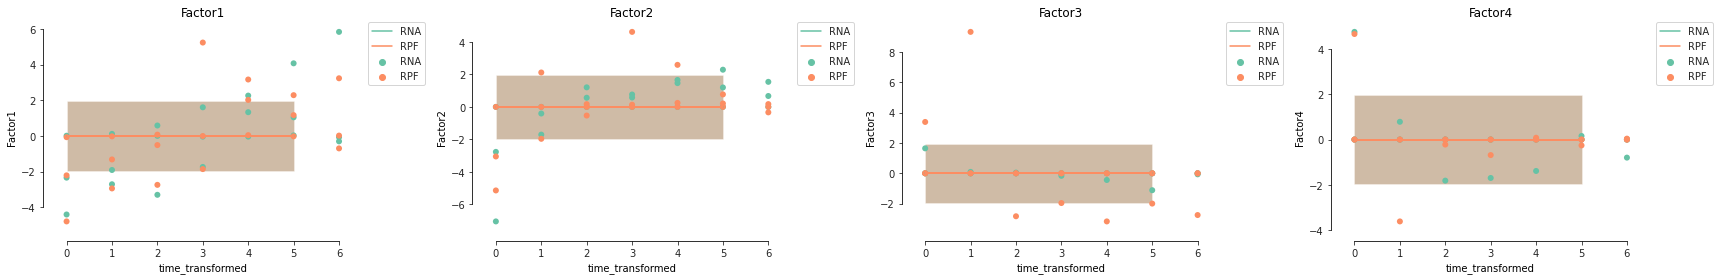

In [199]:
mofax.plot_interpolated_factors(model, factors=range(model.nfactors),
                                ncols=5, size=70)

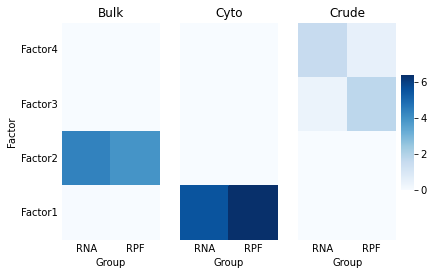

In [200]:
mofax.plot_r2(model, cmap='Blues')

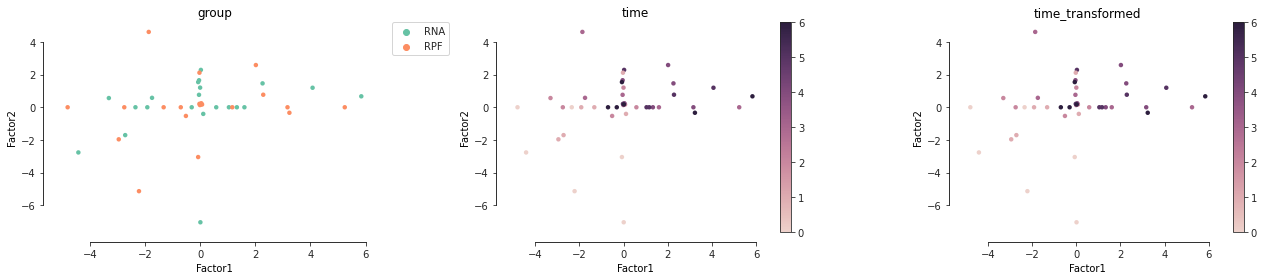

In [201]:
mofax.plot_factors_scatter(model, x = 0, y = 1, color=['group', 'time', 'time_transformed'])

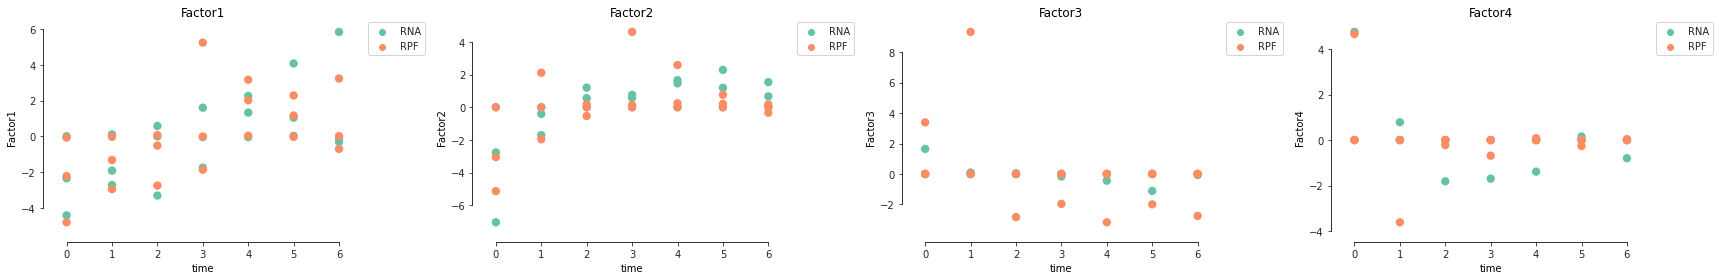

In [202]:
mofax.plot_factors_scatter(model, x = 'time', y=range(model.nfactors),
                           ncols=5, size=70)

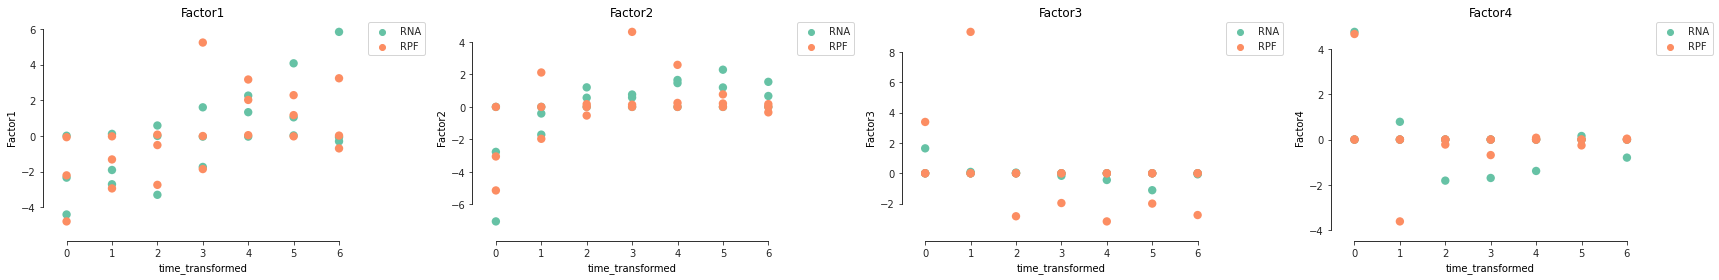

In [203]:
mofax.plot_factors_scatter(model, x = 'time_transformed', y = range(model.nfactors),
                           ncols = 4, size = 70)

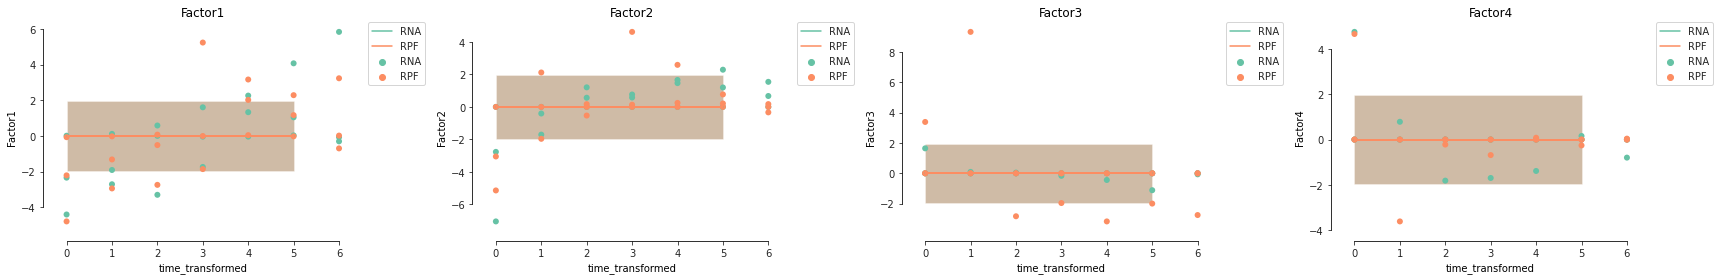

In [204]:
mofax.plot_interpolated_factors(model, factors = range(model.nfactors),
                                ncols = 4, size = 70)

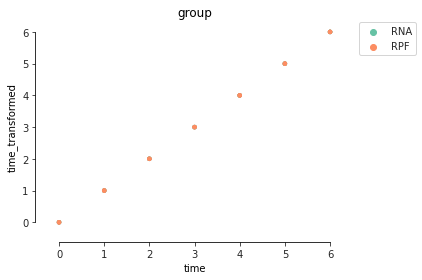

In [205]:
mofax.plot_factors_scatter(model, x = 'time', y = 'time_transformed')

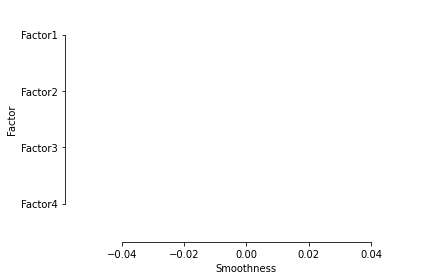

In [207]:
mofax.plot_smoothness(model)

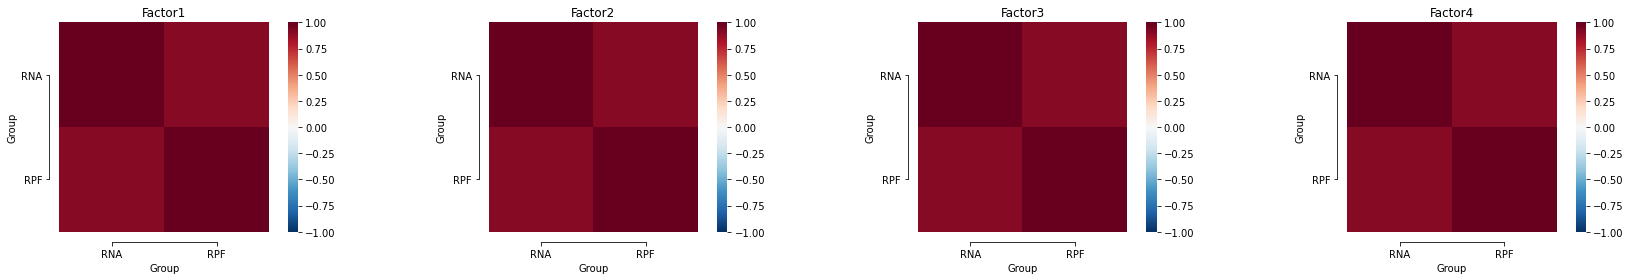

In [208]:
mofax.plot_group_kernel(model, ncols = 5)

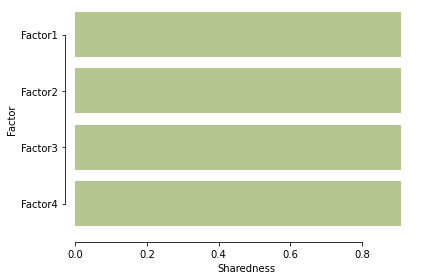

In [209]:
mofax.plot_sharedness(model)

In [210]:
model

MOFA+ model: mefisto translation
Samples (cells): 42
Features: 25359
Groups: RNA (21), RPF (21)
Views: Bulk (8453), Crude (8453), Cyto (8453)
Factors: 4
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: time
Interpolated factors for 6 new values

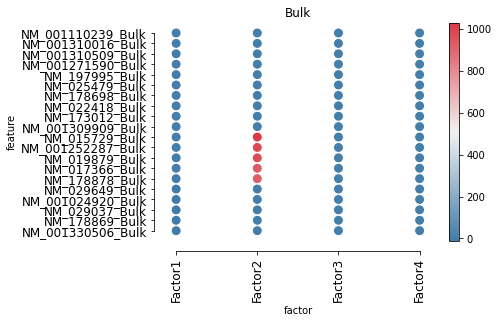

In [212]:
mofax.plot_weights_dotplot(model, view = 'Bulk', size=100,
                           yticklabels_size = 12, xticklabels_size = 12)

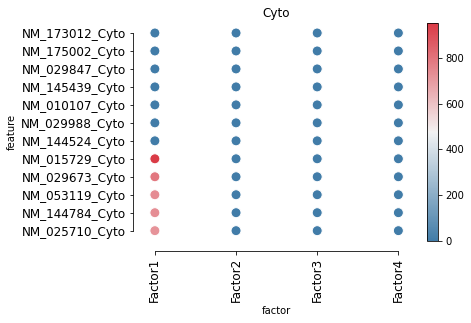

In [213]:
mofax.plot_weights_dotplot(model, view = 'Cyto', size=100,
                           yticklabels_size = 12, xticklabels_size = 12)

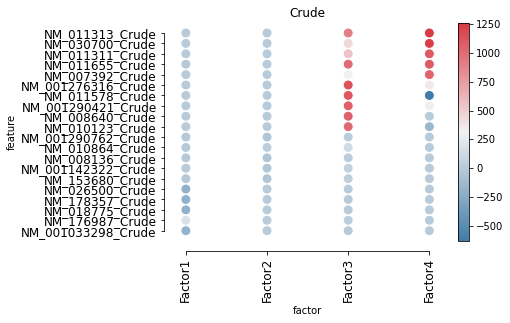

In [214]:
mofax.plot_weights_dotplot(model, view = 'Crude', size=100,
                           yticklabels_size = 12, xticklabels_size = 12)

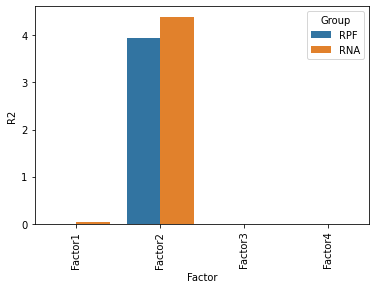

In [215]:
mofax.plot_r2_barplot(model)

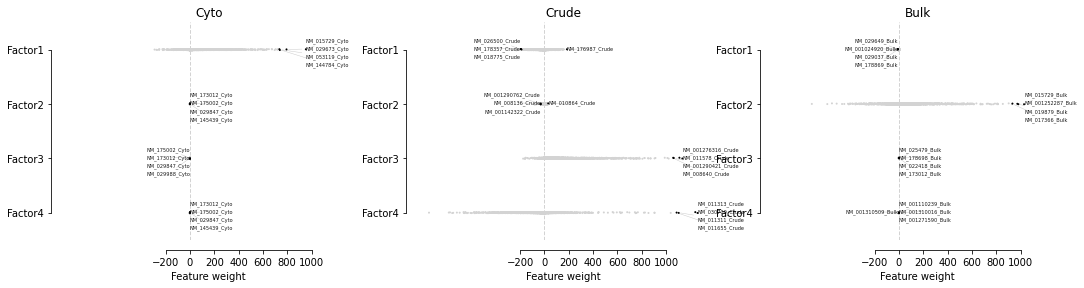

In [216]:
mofax.plot_weights(model, factor=2, n_features=4,
                   y_repel_coef=0.04, x_rank_offset=-100)

In [217]:
model.get_top_features()

array(['NM_011313_Crude', 'NM_030700_Crude', 'NM_011311_Crude',
       'NM_011655_Crude', 'NM_007392_Crude', 'NM_001081213_Crude',
       'NM_009621_Crude', 'NM_146217_Crude', 'NM_001199296_Crude',
       'NM_053110_Crude', 'NM_173012_Cyto', 'NM_175002_Cyto',
       'NM_029847_Cyto', 'NM_145439_Cyto', 'NM_010107_Cyto',
       'NM_029988_Cyto', 'NM_001005788_Cyto', 'NM_175271_Cyto',
       'NM_144524_Cyto', 'NM_001309909_Cyto', 'NM_001110239_Bulk',
       'NM_001310016_Bulk', 'NM_001310509_Bulk', 'NM_001271590_Bulk',
       'NM_197995_Bulk', 'NM_031998_Bulk', 'NM_026068_Bulk',
       'NM_029236_Bulk', 'NM_001286972_Bulk', 'NM_175285_Bulk',
       'NM_001276316_Crude', 'NM_011578_Crude', 'NM_001290421_Crude',
       'NM_008640_Crude', 'NM_010123_Crude', 'NM_145941_Crude',
       'NM_029735_Crude', 'NM_172463_Crude', 'NM_001033311_Cyto',
       'NM_025479_Bulk', 'NM_178698_Bulk', 'NM_022418_Bulk',
       'NM_173012_Bulk', 'NM_001309909_Bulk', 'NM_001034862_Bulk',
       'NM_027532_Bulk', 

In [218]:
ent.set_data_options()
ent.set_data_df(data)



Loaded group='RNA' view='Bulk' with N=7 samples and D=8453 features...
Loaded group='RNA' view='Crude' with N=7 samples and D=8453 features...
Loaded group='RNA' view='Cyto' with N=7 samples and D=8453 features...
Loaded group='RPF' view='Bulk' with N=7 samples and D=8453 features...
Loaded group='RPF' view='Crude' with N=7 samples and D=8453 features...
Loaded group='RPF' view='Cyto' with N=7 samples and D=8453 features...




In [219]:
ent.set_model_options(factors=4)
ent.set_train_options()


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (Bulk): gaussian
- View 1 (Crude): gaussian
- View 2 (Cyto): gaussian




In [220]:
times = [data[['sample', 'time', 'group']].drop_duplicates().set_index('sample').loc[np.concatenate(ent.data_opts['samples_names'])].query('group == @g').time.values.reshape(-1, 1) for g in ent.data_opts['groups_names']]
idx = np.where(ent.data_opts['groups_names'] == 'RNA')

In [228]:
idx = ent.data_opts['groups_names'].index('RNA')

In [229]:
idx

0

In [230]:
ent.set_covariates(times, covariates_names='time')
ent.set_smooth_options(warping=True, warping_ref=idx, model_groups=True)

Loaded 1 covariate(s) for each sample...


##
## Warping set to True: aligning the covariates across groups
##


In [231]:
ent.build()
ent.run()
ent.predict_factor(new_covariates=np.arange(0, 6).reshape(-1, 1))
ent.save('mefisto_bff.hdf5')



######################################
## Training the model with seed 421424 ##
######################################


ELBO before training: -949899183078.85 

Iteration 1: time=0.18, ELBO=-2735047.94, deltaELBO=949896448030.909 (99.99971207%), Factors=4
Iteration 2: time=0.17, ELBO=-2449048.33, deltaELBO=285999.608 (0.00003011%), Factors=4
Iteration 3: time=0.17, ELBO=-2431596.66, deltaELBO=17451.674 (0.00000184%), Factors=4
Iteration 4: time=0.17, ELBO=-2422285.41, deltaELBO=9311.242 (0.00000098%), Factors=4
Iteration 5: time=0.18, ELBO=-2416239.57, deltaELBO=6045.843 (0.00000064%), Factors=4
Iteration 6: time=0.17, ELBO=-2411923.63, deltaELBO=4315.941 (0.00000045%), Factors=4
Iteration 7: time=0.17, ELBO=-2408615.91, deltaELBO=3307.716 (0.00000035%), Factors=4
Iteration 8: time=0.17, ELBO=-2405888.11, deltaELBO=2727.807 (0.00000029%), Factors=4
Iteration 9: time=0.17, ELBO=-2403502.66, deltaELBO=2385.444 (0.00000025%), Factors=4
Iteration 10: time=0.20, ELBO=-2401378.67, deltaE

In [232]:
m = mofax.mofa_model('mefisto_bff.hdf5')

In [233]:
m

MOFA+ model: mefisto bff
Samples (cells): 42
Features: 25359
Groups: RNA (21), RPF (21)
Views: Bulk (8453), Crude (8453), Cyto (8453)
Factors: 4
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: time
Interpolated factors for 6 new values

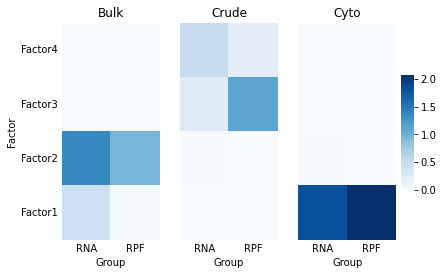

In [234]:
mofax.plot_r2(m, cmap='Blues')

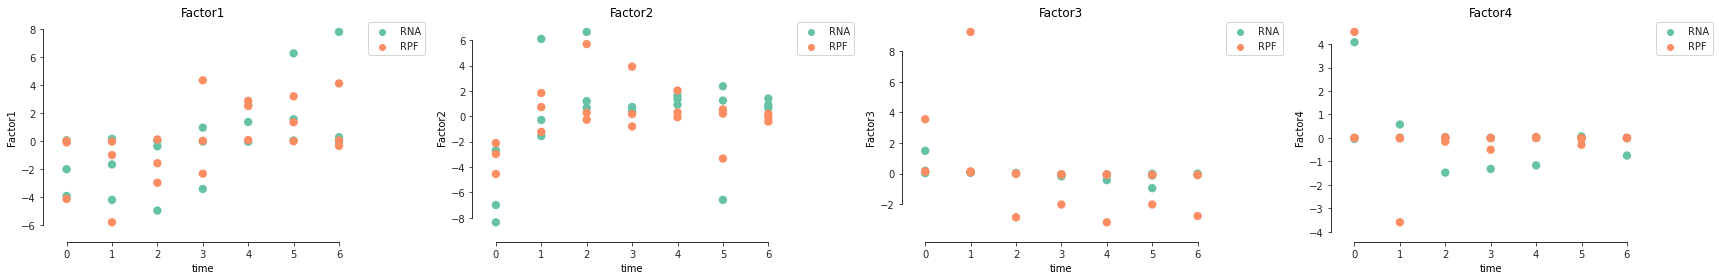

In [235]:
mofax.plot_factors_scatter(m, x='time', y=range(m.nfactors),
                           ncols=5, size=70)

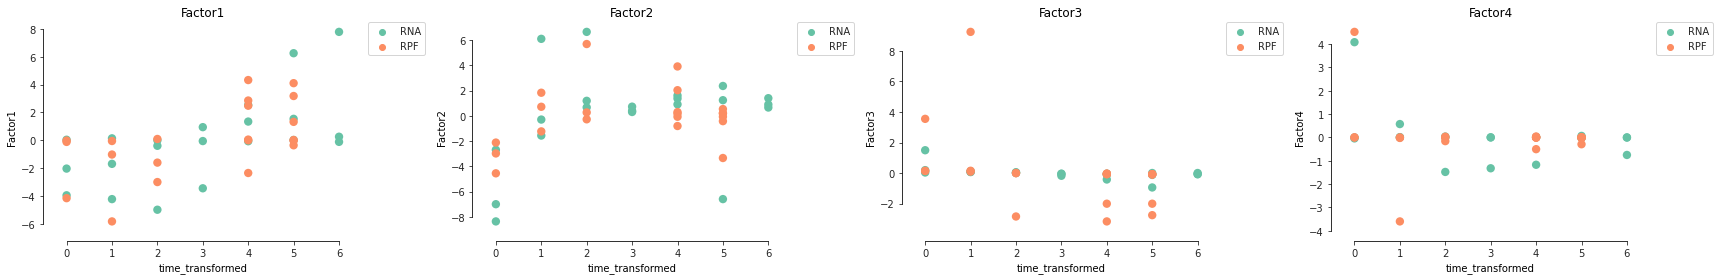

In [236]:
mofax.plot_factors_scatter(m, x='time_transformed', y=range(m.nfactors),
                           ncols=4, size=70)

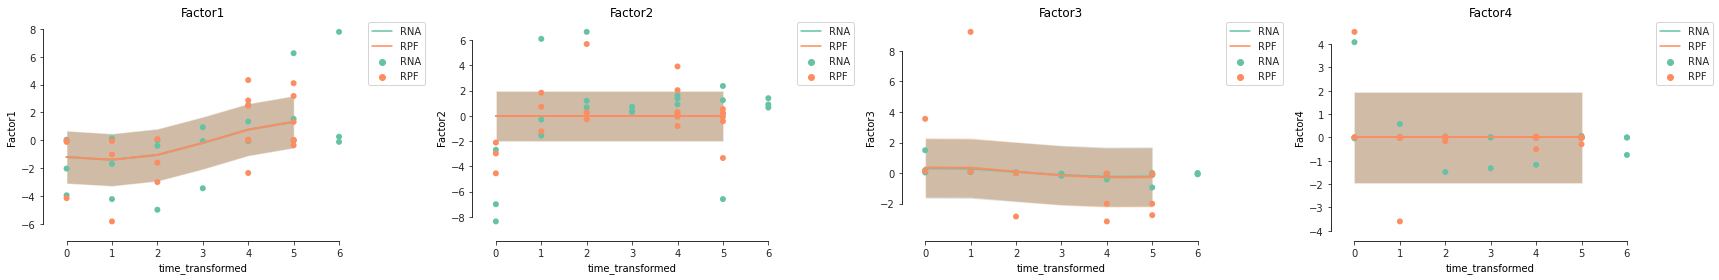

In [237]:
mofax.plot_interpolated_factors(m, factors=range(m.nfactors),
                                ncols=4, size=70)

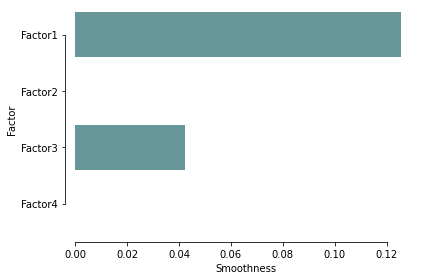

In [238]:
mofax.plot_smoothness(m)

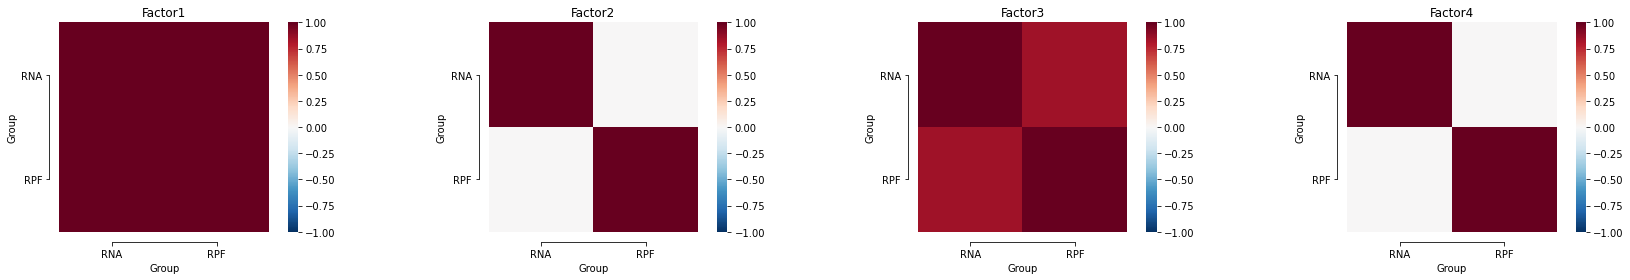

In [239]:
mofax.plot_group_kernel(m, ncols=4)

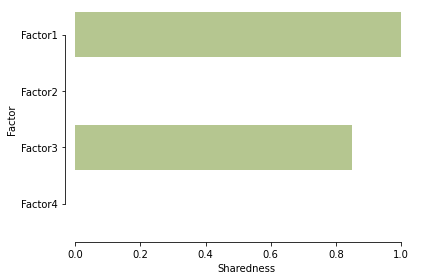

In [240]:
mofax.plot_sharedness(m)

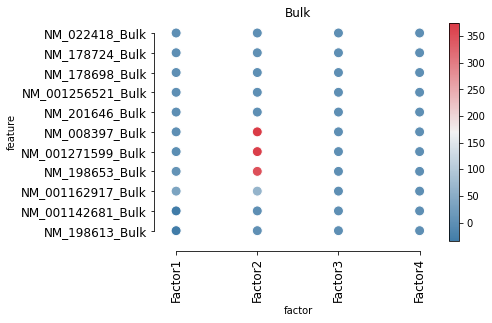

In [241]:
mofax.plot_weights_dotplot(m, view='Bulk', n_features=3,
                           yticklabels_size=12, xticklabels_size=12, size=100)

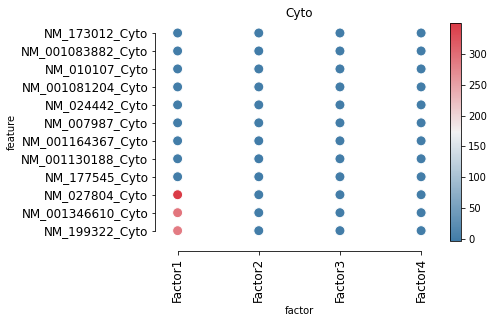

In [242]:
mofax.plot_weights_dotplot(m, view='Cyto', n_features=3,
                           yticklabels_size=12, xticklabels_size=12, size=100)

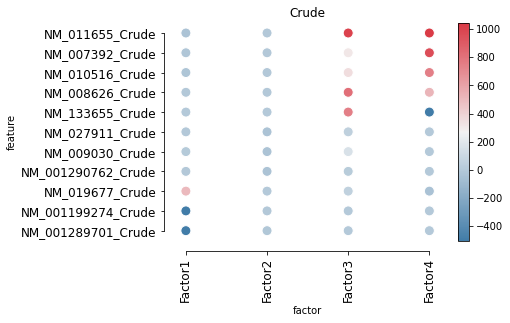

In [243]:
mofax.plot_weights_dotplot(m, view='Crude', n_features=3,
                           yticklabels_size=12, xticklabels_size=12, size=100)

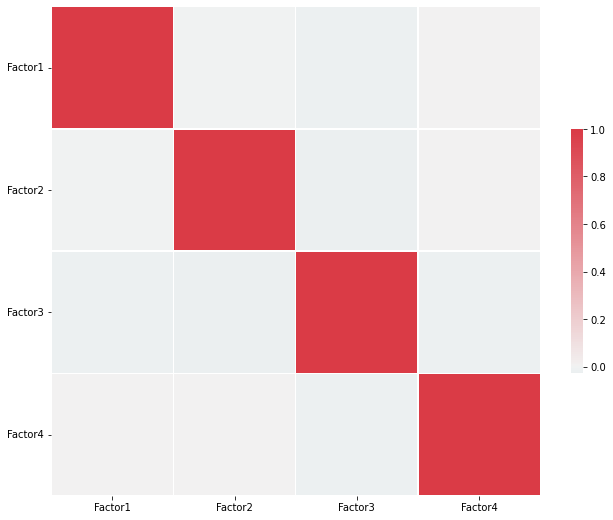

In [244]:
mofax.plot_weights_correlation(model)

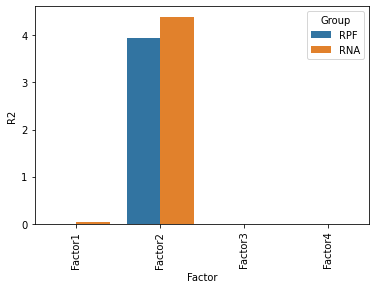

In [245]:
mofax.plot_r2_barplot(model)